In [1]:
from icecream import ic
from pyforest import *
import pyforest; pyforest.disable_javascript_update()
from lovely_numpy import lo

In [2]:
import random
import math
import re
import itertools
from collections import Counter
from functools import partial
from tqdm import trange
import pickle

# Move utils to head.
import hu_utils
import importlib
hu_utils = importlib.reload(hu_utils)
from sklearn.utils import shuffle

from skopt.learning import RandomForestRegressor as opt_RF
from skopt.learning import ExtraTreesRegressor as opt_ET
import sklearn.gaussian_process as gp
plt.style.use('classic')
import seaborn as sns
# sns.set_style('whitegrid')
import plt_configs; importlib.reload(plt_configs)

import shap

<IPython.core.display.Javascript object>

In [3]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    cross_validate, train_test_split
)
from sklearn.ensemble import RandomForestRegressor
from joblib import dump
from joblib import load

In [49]:
# 180 points.
dfs0 = pd.read_excel("ML_ei&pred (1&2&3rounds)_20240408.xlsx", engine = "openpyxl", sheet_name=0) # 80 points
dfs1 = pd.read_excel("ML_ei&pred (1&2&3rounds)_20240408.xlsx", engine = "openpyxl", sheet_name=1) # 50 points

In [50]:
df = pd.concat([dfs0, dfs1], axis=0, ignore_index=True)

In [51]:
df.head()

,ML,NO.,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,RFR-RFR,1,0.07,0.33,0.03,0.34,0.23,0.01,115.39
1,NaN,2,0.07,0.28,0.02,0.04,0.38,0.20,182.99
2,NaN,3,0.02,0.46,0.07,0.05,0.17,0.24,149.58
3,NaN,4,0.07,0.38,0.04,0.05,0.14,0.32,87.98
4,NaN,5,0.09,0.42,0.06,0.23,0.14,0.05,123.14


In [52]:
df.tail()

,ML,NO.,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
205,NaN,6,0,0.65,0.00,0.08,0.27,0.00,245.10
206,NaN,7,0,0.67,0.00,0.08,0.25,0.00,232.07
207,NaN,8,0,0.63,0.00,0.05,0.32,0.00,200.08
208,NaN,9,0,0.68,0.00,0.07,0.25,0.00,250.98
209,NaN,10,0,0.48,0.00,0.06,0.45,0.00,199.12


In [53]:
df.shape

(210, 9)

In [54]:
df_dedup = df.drop_duplicates(subset='Glass (kPa)_max', ignore_index=True)

In [55]:
df_dedup

,ML,NO.,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,RFR-RFR,1,0.07,0.33,0.03,0.34,0.23,0.01,115.39
1,NaN,2,0.07,0.28,0.02,0.04,0.38,0.20,182.99
2,NaN,3,0.02,0.46,0.07,0.05,0.17,0.24,149.58
3,NaN,4,0.07,0.38,0.04,0.05,0.14,0.32,87.98
4,NaN,5,0.09,0.42,0.06,0.23,0.14,0.05,123.14
...,...,...,...,...,...,...,...,...,...
158,NaN,8,0.01,0.41,0.02,0.00,0.40,0.16,62.22
159,NaN,9,0.15,0.37,0.01,0.08,0.39,0.01,148.00
160,NaN,3,0,0.61,0.00,0.08,0.31,0.00,229.75
161,NaN,7,0,0.67,0.00,0.08,0.25,0.00,232.07


In [56]:
df_dedup.columns

Index(['ML', 'NO.', 'Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA',
       'Cationic-ATAC', 'Aromatic-PEA', 'Amide-AAm', 'Glass (kPa)_max'],
      dtype='object')

In [57]:
df_dedup = df_dedup[['Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA',
       'Cationic-ATAC', 'Aromatic-PEA', 'Amide-AAm', 'Glass (kPa)_max']]
df_dedup.dropna(inplace=True)

In [58]:
df_dedup

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,0.07,0.33,0.03,0.34,0.23,0.01,115.39
1,0.07,0.28,0.02,0.04,0.38,0.20,182.99
2,0.02,0.46,0.07,0.05,0.17,0.24,149.58
3,0.07,0.38,0.04,0.05,0.14,0.32,87.98
4,0.09,0.42,0.06,0.23,0.14,0.05,123.14
...,...,...,...,...,...,...,...
158,0.01,0.41,0.02,0.00,0.40,0.16,62.22
159,0.15,0.37,0.01,0.08,0.39,0.01,148.00
160,0,0.61,0.00,0.08,0.31,0.00,229.75
161,0,0.67,0.00,0.08,0.25,0.00,232.07


In [59]:
no_gel_row = df_dedup[df_dedup['Glass (kPa)_max']=='NO GELATION']
df_reduce_no = df_dedup.drop(index=no_gel_row.index)

In [60]:
# no_gel_row
df_reduce_no

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,0.07,0.33,0.03,0.34,0.23,0.01,115.39
1,0.07,0.28,0.02,0.04,0.38,0.20,182.99
2,0.02,0.46,0.07,0.05,0.17,0.24,149.58
3,0.07,0.38,0.04,0.05,0.14,0.32,87.98
4,0.09,0.42,0.06,0.23,0.14,0.05,123.14
...,...,...,...,...,...,...,...
158,0.01,0.41,0.02,0.00,0.40,0.16,62.22
159,0.15,0.37,0.01,0.08,0.39,0.01,148.00
160,0,0.61,0.00,0.08,0.31,0.00,229.75
161,0,0.67,0.00,0.08,0.25,0.00,232.07


In [61]:
df_train = pd.read_excel("Original Data_ML_20220829.xlsx", engine = "openpyxl")

In [62]:
df_train = df_train[['Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA',
       'Cationic-ATAC', 'Aromatic-PEA', 'Amide-AAm', 'Glass (kPa)']]
df_train.columns =['Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA',
       'Cationic-ATAC', 'Aromatic-PEA', 'Amide-AAm', 'Glass (kPa)_max'] 

In [63]:
df = pd.concat([df_train, df_reduce_no],axis=0, ignore_index=True)

In [64]:
df

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,0.52,0.20,0.09,0.19,0.00,0.00,22.36
1,0.42,0.41,0.17,0.00,0.00,0.00,12.57
2,0.54,0.11,0.18,0.17,0.00,0.00,10.93
3,0.22,0.20,0.09,0.17,0.32,0.00,126.82
4,0.12,0.41,0.19,0.19,0.09,0.00,109.27
...,...,...,...,...,...,...,...
336,0.01,0.41,0.02,0.00,0.40,0.16,62.22
337,0.15,0.37,0.01,0.08,0.39,0.01,148.00
338,0,0.61,0.00,0.08,0.31,0.00,229.75
339,0,0.67,0.00,0.08,0.25,0.00,232.07


In [65]:
df.to_csv('data/df_341.csv')

### Readin data.

In [4]:
df = pd.read_csv('data/df_341.csv', index_col=0)

In [5]:
df

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,0.52,0.20,0.09,0.19,0.00,0.00,22.36
1,0.42,0.41,0.17,0.00,0.00,0.00,12.57
2,0.54,0.11,0.18,0.17,0.00,0.00,10.93
3,0.22,0.20,0.09,0.17,0.32,0.00,126.82
4,0.12,0.41,0.19,0.19,0.09,0.00,109.27
...,...,...,...,...,...,...,...
336,0.01,0.41,0.02,0.00,0.40,0.16,62.22
337,0.15,0.37,0.01,0.08,0.39,0.01,148.00
338,0.00,0.61,0.00,0.08,0.31,0.00,229.75
339,0.00,0.67,0.00,0.08,0.25,0.00,232.07


In [6]:
x_columns = ['Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA', 'Cationic-ATAC',
       'Aromatic-PEA', 'Amide-AAm']
y_column = 'Glass (kPa)_max'

In [7]:
X = df.loc[:, x_columns]
y = df.loc[:, y_column]

In [8]:
X.shape, y.shape

((341, 6), (341,))

## Fit part.

In [9]:
### Do GridSearchCV for top 8 models
np.random.seed(0)
random.seed(0)
rs = 929

rmse_dict = dict()

In [10]:
# xgb ranges
range_depth = [6, 7, 8]
range_subsample = [0.8, 0.9, 1]
range_colsample = [0.8, 0.9, 1]
range_lr = [0.1, 0.05]

# Common ranges


# For debugging
debug = False
# debug_run = True
if debug:
    # xgb ranges
    range_depth = [3,4]
    range_subsample = [0.9, 1]
    range_colsample = [0.9, 1]
    range_lr = [0.1, 0.05]
ntree = 500

In [11]:
X.head()

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm
0,0.52,0.20,0.09,0.19,0.00,0.00
1,0.42,0.41,0.17,0.00,0.00,0.00
2,0.54,0.11,0.18,0.17,0.00,0.00
3,0.22,0.20,0.09,0.17,0.32,0.00
4,0.12,0.41,0.19,0.19,0.09,0.00


### Utils

In [11]:
import hu_utils
import importlib
hu_utils = importlib.reload(hu_utils)
from sklearn.utils import shuffle

# ic(plt.rcParams['mathtext.default'])
# for k in plt.rcParams:
#     if k.find('tick')!=-1:
#         ic(k ,plt.rcParams[k])

### rf_cv, best_rf_cv, CV object setups and .fit()

In [13]:
rf_cv = hu_utils.setup_gridsearch_model('RFRsk')
rf_cv.fit(X, y)
ic(rf_cv.best_params_)

ic| rf_cv.best_params_: {'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 2}


{'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 2}

In [16]:
y_neg = np.negative(y)
store_model = rf_cv.best_estimator_
store_model.fit(X, y_neg)
dump(rf_cv.best_estimator_, 'model/RFR_best_341.joblib')

['model/RFR_best_341.joblib']

RMSE 18.759 (sd: 0.496, min:18.009, max:19.531, det:0.937) ... train
RMSE 32.743 (sd: 5.356, min:22.981, max:40.665, det:0.785) ... test


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


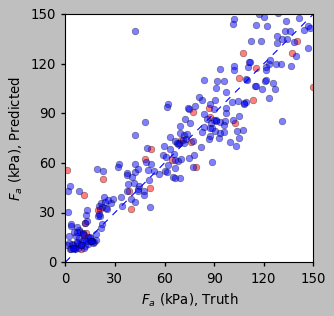

In [76]:
best_rf_cv = hu_utils.BestEstimatorCV(estimator=rf_cv.best_estimator_,
                                      X=X,
                                      y=y,
                                      cv=10)
# best_rf_cv.output_stats_difference()
best_rf_cv.output_stats()
best_rf_cv.plot_hold_out('hold_out_rf_341')
# best_rf_cv.plot_importance(X.columns, topk=6, fname='hold_out_rf_feature_importance')

In [77]:
rmse_dict['RFR'] = best_rf_cv.output_stats()[0]

RMSE 18.759 (sd: 0.496, min:18.009, max:19.531, det:0.937) ... train
RMSE 32.743 (sd: 5.356, min:22.981, max:40.665, det:0.785) ... test


### SHAP plot for RFR

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


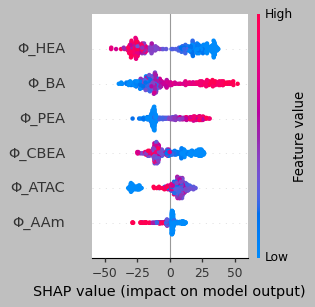

In [14]:
shap.initjs()
explainer = shap.TreeExplainer(rf_cv.best_estimator_)
X.columns = ['Φ_HEA','Φ_BA','Φ_CBEA','Φ_ATAC','Φ_PEA','Φ_AAm']
shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X, plot_type='bar') # Summary bar plot
shap.summary_plot(shap_values, X, show=False, plot_size=(4,4)) # Summary bee-swarm plot
# shap.summary_plot(shap_values, X, plot_type='layered_violin') # Summary bee-swarm plot
# shap.dependence_plot(3, shap_values, X)
# shap.force_plot(explainer.expected_value, shap_values, X)
# shap.plots.waterfall(explainer)
plt.xticks([-50,-25,0,25,50])
plt.savefig('shap/shap_summary_plot_341.pdf')



In [19]:
df_test = pd.DataFrame(shap_values, columns=X.columns)

In [22]:
df_test.to_csv('shap/341_summary_shap_value.csv')

In [23]:
X.to_csv('shap/341_summary_feature_value.csv')

In [48]:
# X.iloc[:,3]

output_force_plot = shap.force_plot(explainer.expected_value, shap_values, X, show=False)
file ='force_plot.html'
shap.save_html(file, output_force_plot)
# lo(shap_values)
# lo(explainer.expected_value)

In [116]:
hu_utils.plot_shap_waterfall(rf_cv.best_estimator_, X, figsize=(4,4))

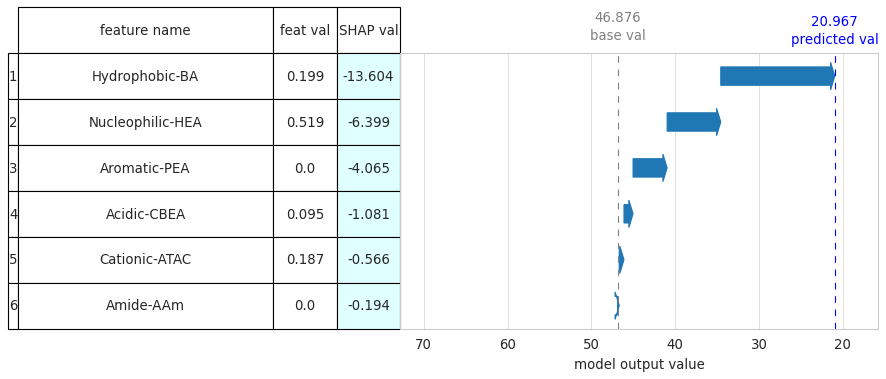

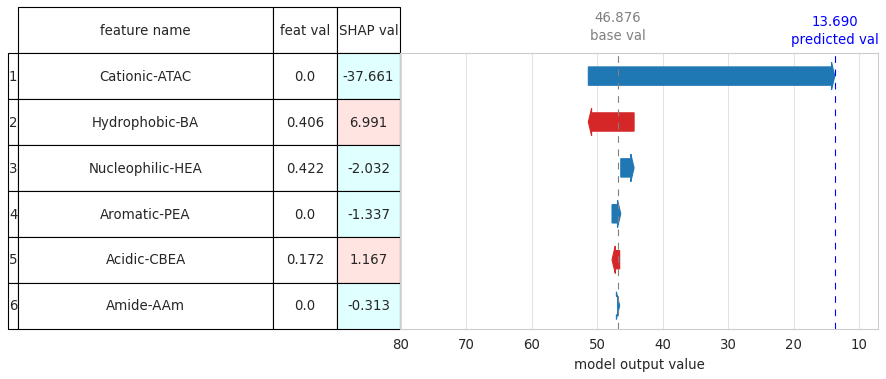

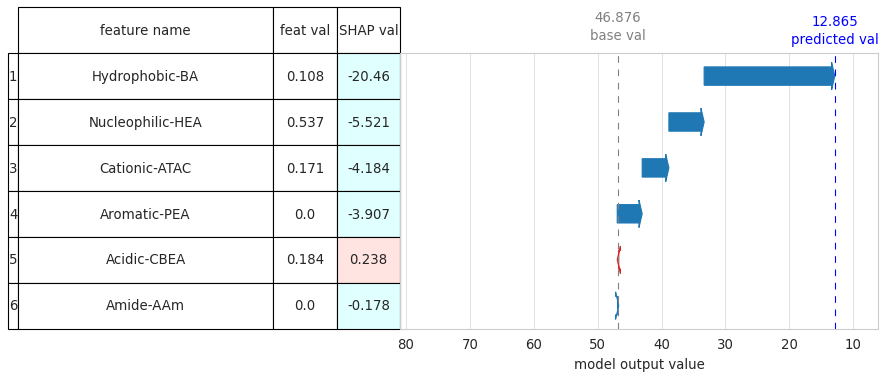

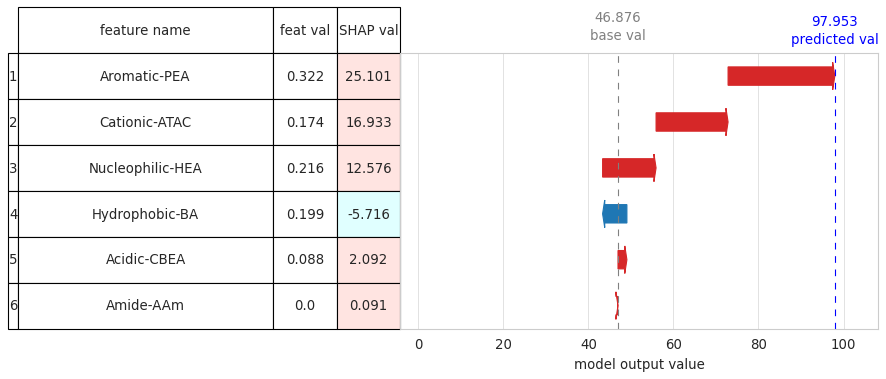

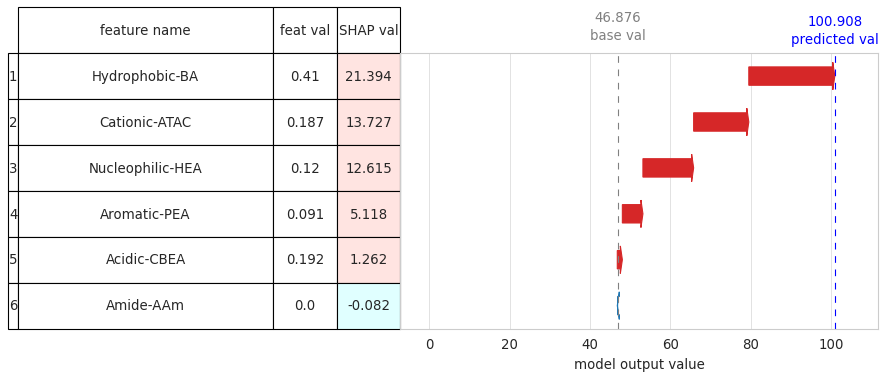

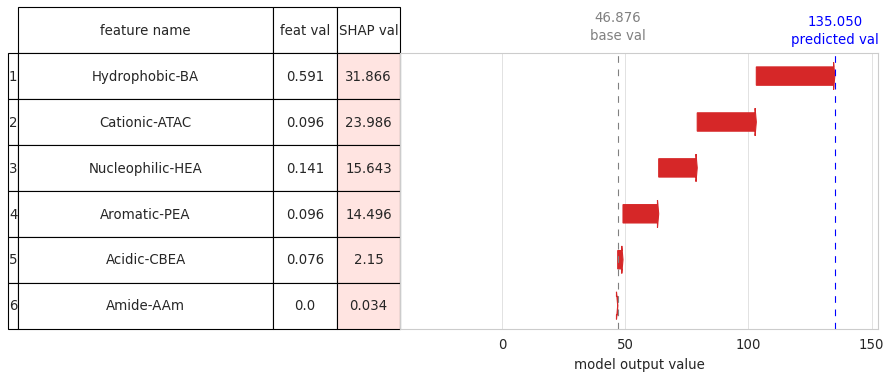

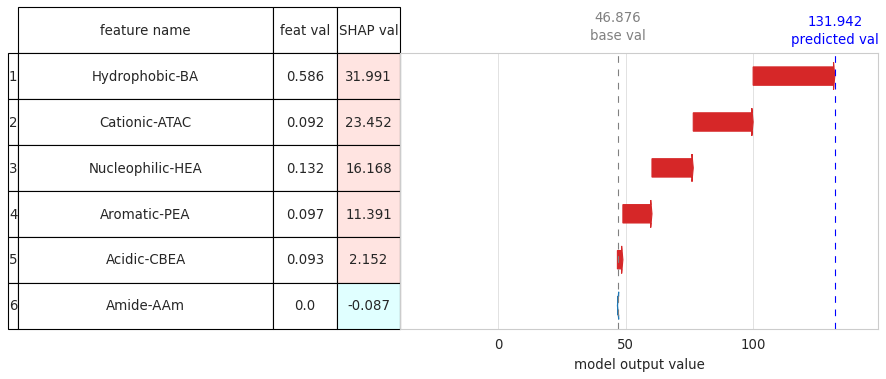

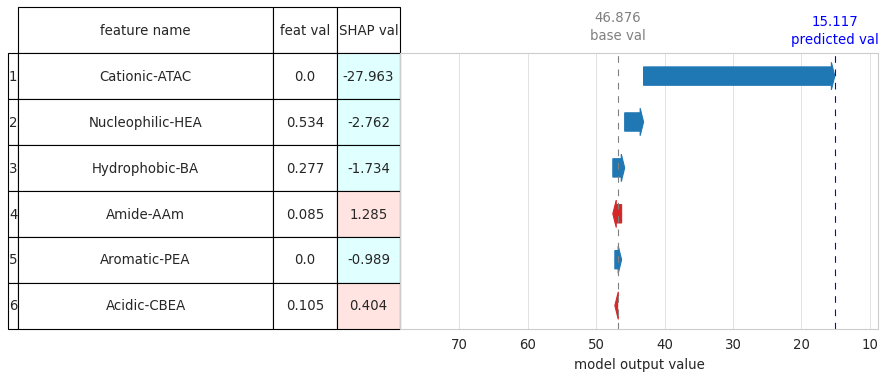

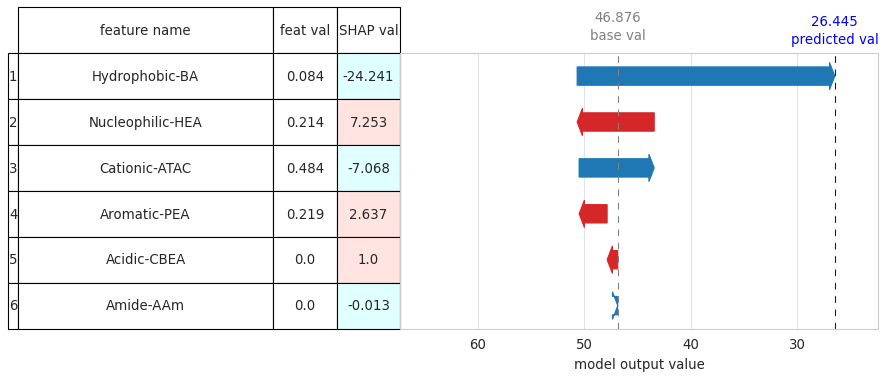

In [52]:
PATH = 'shap/'
import os
os.makedirs(PATH, exist_ok = True)
base_val = y.mean()
for i in range(5):
    cand_name = X.index[i]
    tmp = X.iloc[i, :].astype('float').to_frame()
    tmp.columns = ['val']
    tmp['shap'] = shap_values[i]
    hu_utils.plot_topshap(tmp, base_val, k=6, figsize = (17, 5), save=True) # Revoke the plot_topSHAP()
    plt.savefig(PATH + f'shap_{i}.pdf', bbox_inches='tight')

for i in [41, 106, 179, 85]:
    cand_name = X.index[i]
    tmp = X.iloc[i, :].astype('float').to_frame()
    tmp.columns = ['val']
    tmp['shap'] = shap_values[i]
    hu_utils.plot_topshap(tmp, base_val, k=6, figsize = (17, 5), save=True) # Revoke the plot_topSHAP()
    plt.savefig(PATH + f'shap_{i}.pdf', bbox_inches='tight')

### ETR

ic| etr_cv.best_params_: {'bootstrap': True,
                          'max_features': 1.0,
                          'max_leaf_nodes': 70,
                          'min_samples_leaf': 2}


RMSE 21.571 (sd: 0.597, min:20.606, max:22.350, det:0.917) ... train
RMSE 32.542 (sd: 5.925, min:22.355, max:41.533, det:0.785) ... test


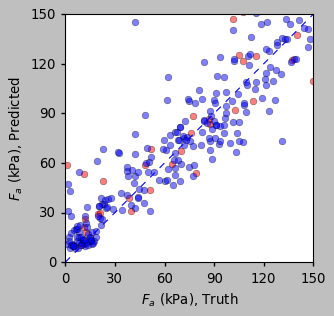

In [80]:
etr_cv = hu_utils.setup_gridsearch_model('ETR')
etr_cv.fit(X, y)
ic(etr_cv.best_params_)
best_etr_cv = hu_utils.BestEstimatorCV(estimator=etr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['ETR'] = best_etr_cv.output_stats()[0]
best_etr_cv.plot_hold_out('hold_out_etr_341')


ic| xgb_cv.best_params_: {'colsample_bytree': 1,
                          'learning_rate': 0.05,
                          'max_depth': 6,
                          'n_estimators': 200,
                          'subsample': 0.9}


RMSE 3.673 (sd: 0.164, min:3.348, max:3.897, det:0.998) ... train
RMSE 33.362 (sd: 6.458, min:23.535, max:44.513, det:0.772) ... test


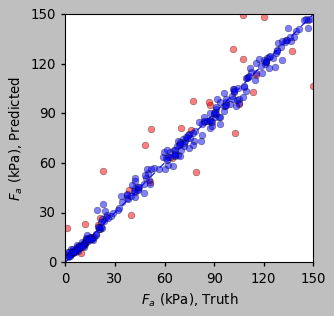

In [81]:
# Need 13 mins.
xgb_cv = hu_utils.setup_gridsearch_model('XGB')
xgb_cv.fit(X, y)
ic(xgb_cv.best_params_)
best_xgb_cv = hu_utils.BestEstimatorCV(estimator=xgb_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['XGB'] = best_xgb_cv.output_stats()[0]
best_xgb_cv.plot_hold_out(f'hold_out_xgb_341')


ic| lasso_cv.best_params_: {'alpha': 1.0}


RMSE 43.591 (sd: 0.517, min:42.550, max:44.364, det:0.662) ... train
RMSE 43.884 (sd: 4.018, min:37.562, max:50.859, det:0.630) ... test


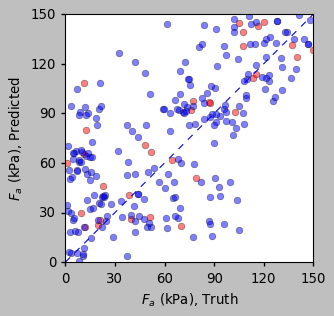

In [82]:
lasso_cv = hu_utils.setup_gridsearch_model('LASSO')
lasso_cv.fit(X, y)
ic(lasso_cv.best_params_)
best_lasso_cv = hu_utils.BestEstimatorCV(estimator=lasso_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['Lasso'] = best_lasso_cv.output_stats()[0]
best_lasso_cv.plot_hold_out('hold_out_lasso_341')


ic| ridge_cv.best_params_: {'alpha': 1.0}


RMSE 41.868 (sd: 0.589, min:40.709, max:42.686, det:0.688) ... train
RMSE 42.165 (sd: 4.879, min:34.493, max:50.873, det:0.654) ... test


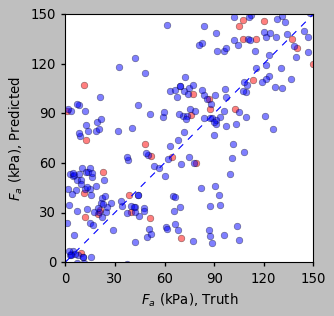

In [83]:
ridge_cv = hu_utils.setup_gridsearch_model('RIDGE')
ridge_cv.fit(X, y)
ic(ridge_cv.best_params_)
best_ridge_cv = hu_utils.BestEstimatorCV(estimator=ridge_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
best_ridge_cv.plot_hold_out(f'hold_out_ridge_341')
rmse_dict['Ridge'] = best_ridge_cv.output_stats()[0]


ic| krr_cv.best_params_: {'alpha': 0.001, 'gamma': 1.0}


RMSE 27.462 (sd: 0.680, min:26.164, max:28.266, det:0.866) ... train
RMSE 31.066 (sd: 6.343, min:21.989, max:42.883, det:0.799) ... test


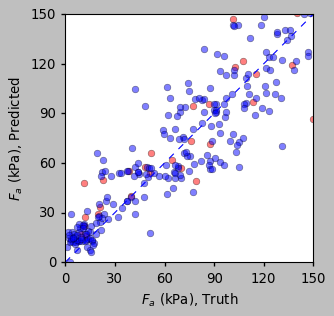

In [84]:
krr_cv = hu_utils.setup_gridsearch_model('KRR')
krr_cv.fit(X, y)
ic(krr_cv.best_params_)
best_krr_cv = hu_utils.BestEstimatorCV(estimator=krr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['KRR'] = best_krr_cv.output_stats()[0]
best_krr_cv.plot_hold_out(f'hold_out_krr_341')


ic| svr_cv.best_params_: {'C': 10000.0, 'epsilon': 10.0, 'gamma': 1.0}


RMSE 28.967 (sd: 0.630, min:27.799, max:29.772, det:0.851) ... train
RMSE 31.070 (sd: 5.727, min:21.343, max:40.046, det:0.803) ... test


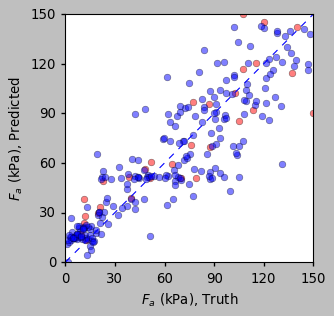

In [85]:
svr_cv = hu_utils.setup_gridsearch_model('SVR')
svr_cv.fit(X, y)
ic(svr_cv.best_params_)
best_svr_cv = hu_utils.BestEstimatorCV(estimator=svr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['SVR'] = best_svr_cv.output_stats()[0]
best_svr_cv.plot_hold_out(f'hold_out_svr_341')


ic| knn_cv.best_params_: {'n_neighbors': 8, 'p': 2}


RMSE 31.299 (sd: 0.913, min:29.249, max:32.482, det:0.826) ... train
RMSE 34.873 (sd: 6.958, min:24.754, max:48.303, det:0.748) ... test


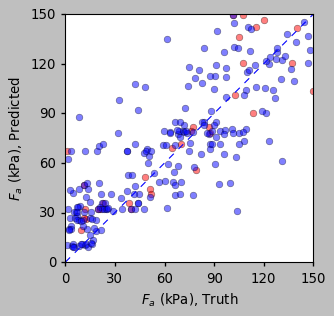

In [86]:
knn_cv = hu_utils.setup_gridsearch_model('KNN')
knn_cv.fit(X, y)
ic(knn_cv.best_params_)
best_knn_cv = hu_utils.BestEstimatorCV(estimator=knn_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['KNN'] = best_knn_cv.output_stats()[0]
best_knn_cv.plot_hold_out(f'hold_out_knn_341')


In [193]:
# dummy_cv = hu_utils.setup_gridsearch_model('DUM')
# dummy_cv.fit(X, y)
# ic(dummy_cv.best_params_)
# best_dummpy_cv = hu_utils.BestEstimatorCV(estimator=dummy_cv.best_estimator_,
#                                        X=X,
#                                        y=y,
#                                        cv=10)
# best_dummpy_cv.output_stats()
# best_dummpy_cv.plot_hold_out(f'hold_out_dummy')


ic| dummy_cv.best_params_: {'strategy': 'mean'}


RMSE 36.054 (sd: 0.563, min:35.151, max:37.091, det:0.000) ... train
RMSE 36.111 (sd: 5.271, min:25.242, max:43.637, det:-0.190) ... test


In [32]:

# ret = {}
# ret[ "trn_mean" ] = 21.236  # 5 fold mean. It's different from the overal rmse.
# ret["trn_std"] = 3.455
# ret["tes_mean"] = 22.808
# ret["tes_std"] = 5.312
# rmse_dict['TabNet'] = ret

In [12]:
gp_cv = hu_utils.setup_gridsearch_model('GP')
gp_cv.fit(X, y)
ic(gp_cv.best_params_)


/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user

{'alpha': 1e-10}

In [ ]:

best_gp_cv = hu_utils.BestEstimatorCV(estimator=gp_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
# best_gp_cv.output_stats()
rmse_dict['GP'] = best_gp_cv.output_stats()[0]
best_gp_cv.plot_hold_out(f'hold_out_gp_341')


In [13]:
y_neg = np.negative(y)
store_model = gp_cv.best_estimator_
store_model.fit(X, y_neg)
dump(gp_cv.best_estimator_, 'model/GP_best_341.joblib')

['model/GP_best_341.joblib']

In [88]:
# Serialization.
with open('data/rmse_dict_341.pkl', 'wb') as f:
    pickle.dump(rmse_dict, f)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


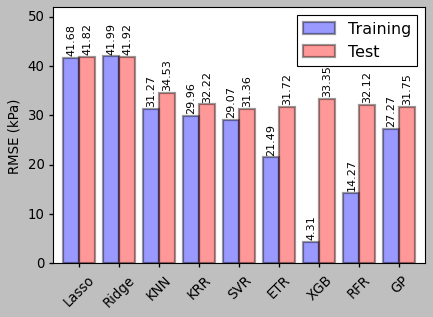

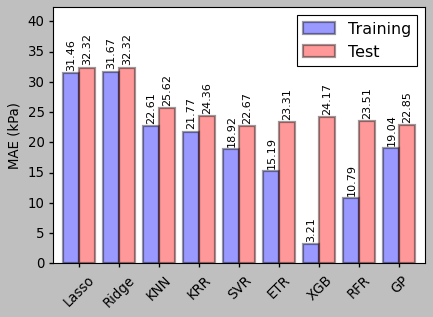

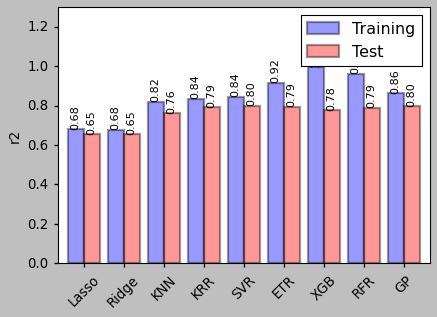

In [89]:
import os
from_scratch = os.path.exists('data/rmse_dict_341.pkl')
if not from_scratch:
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='rmse', updated=True)
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='mae', updated=True)
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='r2', updated=True)
else:
    with open('data/rmse_dict_316.pkl', 'rb') as f:
        rmse_dict = pickle.load(f)
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='rmse', updated=True)
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='mae', updated=True)
    hu_utils.plot_compared_methods_rmse_341(rmse_dict, type='r2', updated=True)
